<center><img src="https://miro.medium.com/v2/resize:fit:300/0*gTbWMTKvNF-jLJrM.jpg" width=30% ></center>

# <center> Assignment 3: Harris Corner Detector & Optical Flow </center>
<center> Computer Vision 1, University of Amsterdam </center>
    <center> Due 23:59PM, September 30, 2023 (Amsterdam time) </center>
    
  ***
<center>
<b>TA's: Melis Öcal, Ronny Velastegui Sandoval</b>

Student1 ID: 15079015 \
Student1 Name: Karim Abdel Sadek

Student2 ID: 13136011\
Student2 Name: Macha Meijer

Student3 ID: \
Student3 Name:

( Student4 ID: \
Student4 Name: )



# General Guidelines

Your code and discussion must be handed in this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 3 Assignment. Please also fill out your names and ID's above.

For full credit, make sure your notebook follows these guidelines:
- It is mandatory to use the Python environment provided with the assignment; the environment specifies the package versions that have to be used to prevent the use of particular functions. Using different packages versions may lead to grade deduction. In the 'Environment Setup' below you can check whether your environment is set up correctly.
- To install the environment with the right package versions, use the following command in your terminal: ```python
conda env create --file=CV1_environment.yaml```, then activate the environment using the command ```python conda activate cv1```.
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions and sub-questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the notebook self-contained and complete.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

__Note:__ A more complete overview of the lab requirements can be found in the Course Manual on Canvas

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations. This includes the use of generative tools such as ChatGPT.

**ENSURE THAT YOU SAVE ALL RESULTS / ANSWERS ON THE QUESTIONS (EVEN IF YOU RE-USE SOME CODE).**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import maximum_filter
from scipy import signal
import os
import matplotlib
import scipy

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert scipy.__version__ == "1.5.4", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

# 1. Harris Corner Detector (45pts)
In this section, a derivation of the [Harris Corner Detector](https://www.semanticscholar.org/paper/A-Combined-Corner-and-Edge-Detector-Harris-Stephens/6818668fb895d95861a2eb9673ddc3a41e27b3b3) is presented.

Given a shift $(\Delta x,\Delta y)$ at a point $((x, y))$, the auto-correlation function is defined as:

\[
\begin{align}
c(\Delta x,\Delta y) = \sum\limits_{(x,y)\in W(x,y)} {w(x,y)(I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {1}
\end{align}
\]

where $(W(x,y))$ is a window centered at point $((x,y))$ and $(w(x,y))$ is a Gaussian function. For simplicity, from now on, $(\sum\limits_{(x,y)\in W(x,y)})$ will be referred to as $(\sum\limits_{W})$.

Approximating the shifted function by the first-order Taylor expansion we get:

\[
\begin{align}
I(x+\Delta x,y+ \Delta y) & \approx I(x,y) + I_x(x,y)\Delta x + I_y(x,y)\Delta y \tag {2} \\
&= I(x,y) + [I_x(x,y) \ I_y(x,y)] \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \tag {3}
\end{align}
\]

where $(I_x)$ and $(I_y)4$ are partial derivatives of $(I(x,y))$. The first gradients can be approximated by:

\[
\begin{align}
    I_x &= \frac{\partial I}{\partial x} \approx I * G_x, \quad G_x = (-1,0,1) \tag {4} \\
    I_y &= \frac{\partial I}{\partial y} \approx I * G_y, \quad G_y = (-1,0,1)^T \tag {5}
\end{align}
\]

Note that using the kernel $(-1, 1)$ to approximate the gradients is also correct. The auto-correlation function can now be written as:

\[
\begin{align}
c(\Delta x,\Delta y) &= \sum\limits_{W} {w(x,y) (I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {6} \\
& \approx \sum\limits_{W} {w(x,y) ([I_x(x,y) \ I_y(x,y)]\begin{bmatrix} \Delta x \\
\Delta y \end{bmatrix})^2} \tag {7} \\
&= [\Delta x \ \Delta y]Q(x,y)\begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \tag {8}
\end{align}
\]

where $(Q(x,y))$ is given by:

\[
\begin{align}
Q(x,y) &= \sum\limits_{W} w(x,y){\begin{bmatrix} I_x(x,y)^2  & I_x(x,y)I_y(x,y)  \\  I_x(x,y)I_y(x,y)  & I_y(x,y)^2   \end{bmatrix}} \tag {9} \\
&= \begin{bmatrix}
\sum\limits_{W}{I_x(x,y)^2} * w(x, y) & \sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) \\  
\sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) & \sum\limits_{W}{I_y(x,y)^2} * w(x, y)  \end{bmatrix} \tag {10}\\
&= \begin{bmatrix} A & B \\  B & C  \end{bmatrix} \tag {11}
\end{align}
\]


The *cornerness* $H(x,y)$ is defined by the two eigenvalues of $Q(x,y)$, e.g. $\lambda_1$ and $\lambda_2$:

\[
\begin{align}
H &= \lambda_1 \lambda_2 - 0.04(\lambda_1 + \lambda_2)^2 \tag{12} \\
&= \text{det}(Q) - 0.04(\text{trace}(Q))^2 \tag{13} \\
&= (AC - B^2) - 0.04(A+C)^2 \tag{14}
\end{align}
\]

In this section, you are going to implement eq 12 to calculate $H$ and use it to detect the corners in an image.

**Hint**: For that purpose, you need to compute the elements of **Q**, i.e. $A$, $B$ and $C$. To do that, you need to calculate $I_x$, which is the smoothed derivative of the image. That can be obtained by convolving the first order Gaussian derivative, $G_d$, with the image $I$ along the x-direction. Then, **A** can be obtained by squaring $I_x$, and then convolving it with a Gaussian, $G$. Similarly, **B** and **C** can be obtained. For example, to get **C**, you need to convolve the image with $G_d$ along the y-direction (to obtain $I_y$), raise it to the square, then convolve it with $G$.

**Hint**: The corner points are the local maxima of **H**. Therefore, you should check for every point in $H$, (1) if it is greater than all its neighbours (in an $n \times n$ window centered around this point) and (2) if it is greater than the user-defined threshold. If both conditions are met, then the point is labeled as a corner point.

## Question 1.1 (35-*pts*)
    
**1.1.1** Create a function to implement the Harris Corner Detector. Your function should return matrix $H$, the indices of rows of the detected corner points **r**, and the indices of columns of those points **c**, where the first corner is given by $(r[0],c[0])$. **[20pts]**

    
**1.1.2** Implement another function that plots three figures: The computed image derivatives $I_x$ and $I_y$, and the original image with the corner points plotted on it. Show your results on example images **checkerboard.jpg** and **house.jpg**. Remember to experiment with different threshold values to see the impact on which corners are found. **[5pts]**
    
    
**1.1.3** Is the algorithm rotation-invariant? How about your implementation? Rotate **checkerboard.jpg** image 45 and 90 degrees and run the Harris Corner Detector algorithm on the rotated images. Explain your answer and support it with your observations. **[10pts]**

*Note:* You are allowed to use *scipy.signal.convolve2d* to perform convolution, and *scipy.ndimage.gaussian\_filter* to obtain your image derivatives.
Include a demo function to run your code.

In [3]:
def img2gray(img_path):
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    #img_gray= np.float32(img_gray)
    return img_gray

def gradient_x(img_gray):
    """
    Compute and return the derivative of the image in the x direction
    """
    x_gradient_kernel = np.array([-1, 0, 1])
    Gx = scipy.signal.convolve2d(img_gray, x_gradient_kernel.reshape(1, -1), mode='same')
    return Gx

def gradient_y(img_gray):
    """
    Compute and return the derivative of the image in the y direction
    """
    y_gradient_kernel = np.array([-1, 0, 1])
    Gy = scipy.signal.convolve2d(img_gray, y_gradient_kernel.reshape(-1, 1), mode='same')
    return Gy

def haris_corner_detector(img_path, sigma, threshold):
    """
    Implement the Harris Corner Detector function as described above.
    Remember, your function should return matrix H, the indices of rows of
    the detected corner points r, and the indices of columns of those points
    c, where the first corner is given by (r[0],c[0]).
    """
    img_gray = img2gray(img_path)
    
    # Apply Gaussian filter before computing gradients
    img_smoothed = scipy.ndimage.gaussian_filter(img_gray, sigma=sigma)

    
    Ix = gradient_x(img_smoothed)
    Iy = gradient_y(img_smoothed)
   
    
    A = scipy.ndimage.gaussian_filter(Ix ** 2, sigma=sigma)
    B = scipy.ndimage.gaussian_filter(Ix * Iy, sigma=sigma)
    C = scipy.ndimage.gaussian_filter(Iy ** 2, sigma=sigma)
    
    
    det_Q = A * C - B ** 2
    trace_Q = A + C
    H = det_Q - 0.04 * (trace_Q ** 2)
   # print(H.min())
    
 
    neighborhood = 5
    maxima = scipy.ndimage.maximum_filter(H, neighborhood)
   
    r, c = np.where( (H == maxima) & (H > threshold))
    
    return H, r, c
    raise NotImplementedError()



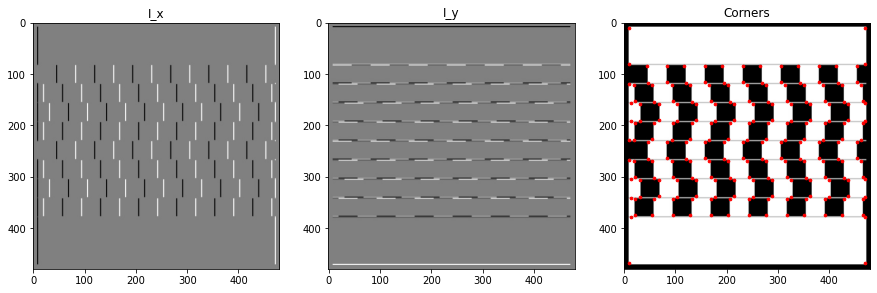

In [4]:
# Now implement another function that plots three figures: The computed image
# derivatives  𝐼_x, 𝐼_y and the original image with the corner points plotted
# on it. Show your results on example images checkerboard.jpg and
# house.jpg. Remember to experiment with different threshold values
# to see the impact on which corners are found.

img_path_checkerboard = './data/checkerboard.jpg'
img_path_house = './data/house.jpg'

img_checkerboard = img2gray(img_path_checkerboard)
img_house = img2gray(img_path_house)

def plot_derivatives_and_corners(img_path, sigma, threshold):
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    Ix = gradient_x(img_gray)
    Iy = gradient_y(img_gray)
    
    H, r, c = haris_corner_detector(img_path, sigma, threshold)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(Ix, cmap='gray')
    plt.title('I_x')
    
    plt.subplot(1, 3, 2)
    plt.imshow(Iy, cmap='gray')
    plt.title('I_y')
    if img_path == './data/house.jpg':
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB))
        plt.scatter(c, r, color='red', s=0.7)
        plt.title('Corners')
    else:
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB))
        plt.scatter(c, r, color='red', s=7)
        plt.title('Corners')

    
    plt.show()
plot_derivatives_and_corners('./data/checkerboard.jpg', 2, 1)


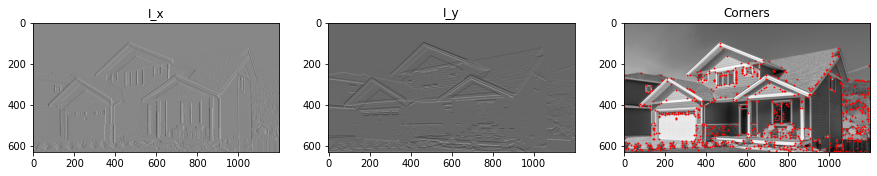

In [5]:
plot_derivatives_and_corners('./data/house.jpg', 3, 40)

The treshold and the sigma values have been tuned for those two different images, in order to obtain satisfying results. We see that in both image we detect the corners with a high accuracy. The outputs are, in fact, very close to the result obtained by running the algorithm implemented in the library opencv

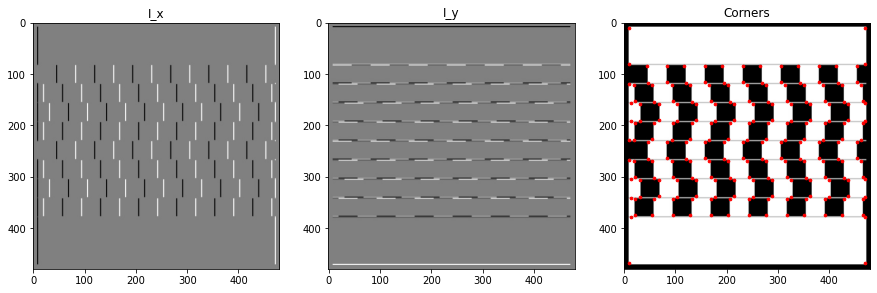

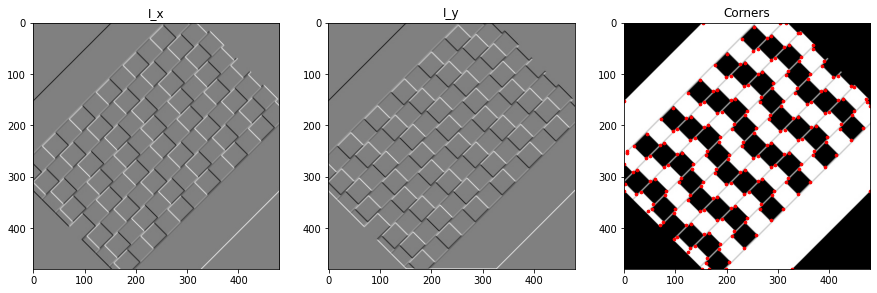

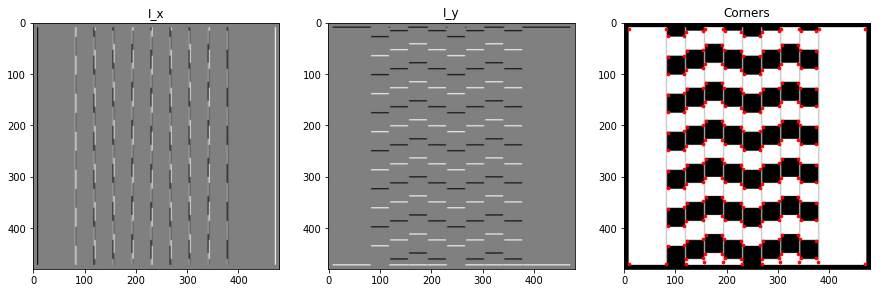

In [6]:
def rotate_and_save_image(image, angle, output_path):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    cv2.imwrite(output_path, rotated)
    return output_path


image = cv2.imread('./data/checkerboard.jpg')


path_45 = rotate_and_save_image(image, 45, 'rotated_45.jpg')
path_90 = rotate_and_save_image(image, 90, 'rotated_90.jpg')

plot_derivatives_and_corners('./data/checkerboard.jpg', 2, 100)
plot_derivatives_and_corners(path_45, 2, 100)
plot_derivatives_and_corners(path_90, 2, 100)

As we can see, the edges detected are the same also if rotating the image.

In [7]:
H, r, c = haris_corner_detector('./data/checkerboard.jpg', 2, 100)
H, r45, c45 = haris_corner_detector(path_45, 2, 100)
H, r90, c90 = haris_corner_detector(path_90, 2, 100)

The cornerness computed in the Harris Corner Detector algorithm depends on the eigenvalues of our matrix. As explicitely explained in the next section, we know that eigenvalues are rotation invariant. Thus, the Harris Corner Detector algorithm is rotation invariant. 

This also holds for our implementation, as the experiments above show. We see that by rotating the checkboard by 45 and 90 degress, the corners detected are the same. We also double-checked this by showing that the number of corners found in the 3 cases ( normal image, rotated by 45 and by 90 degrees) are the same. It also follows mathematically that our implementation should be rotation invariant. 


In [8]:
'''''''''
Checking the output using the cv2 library
image = cv2.imread('./data/house.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)

dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
image[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.figure(figsize = [10, 10])
plt.axis('off')
plt.imshow(image[:,:,::-1])
'''''''''''

"\nChecking the output using the cv2 library\nimage = cv2.imread('./data/house.jpg')\n\ngray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n\ngray = np.float32(gray)\n\ndst = cv2.cornerHarris(gray, 2, 3, 0.04)\ndst = cv2.dilate(dst, None)\nimage[dst > 0.01 * dst.max()] = [0, 0, 255]\nplt.figure(figsize = [10, 10])\nplt.axis('off')\nplt.imshow(image[:,:,::-1])\n"

## Question 1.2 (10-*pts*)
    
Now you have seen the cornerness definition of Harris on $Equation ~(12)$. Another relevant definition of cornerness is defined by  *[Shi and Tomasi](https://ieeexplore.ieee.org/document/323794)*, after the original definition of Harris. Check their algorithm and answer the following questions:
    
**1.2.1** How do they define cornerness? Write down their definition using the notations of $Equation ~(12)$. **[3pts]**
    

Shi and Tomas define their matrix as $Z$. 
The cornerness is defined again in terms of the Eigenvalues of the matrix Z, as similary for Q in the Haris Corner Detection algorithm. Note that Z and Q are the same matrix. There is just a difference in notation.  The definition of cornerness is the following: 


\begin{align}
 \min(\lambda_1 ,\lambda_2)
\end{align}


A window is accepted as a corner if and only if 


\begin{align}
 \min(\lambda_1 ,\lambda_2) > \lambda
\end{align}


for a given treshold $\lambda$

**1.2.2** Does the Shi-Tomasi Corner Detector satisfy the following properties: translation invariance, rotation invariance, scale invariance? Explain your reasoning for each property. **[4pts]**
    

Let's address the 3 properties. 

1. The Corner Detector algorithms is translation invariant. This is because the eigenvalues and the second moment matrix(in our case Z) are not affected by translation.

2. The Corner Detector algorithms is rotation invariant. This is because the eigenvalues and the second moment matrix(in our case Z) are not affected by rotation. 

Regarding these two properties, recall that the eigenvalues represent the factor by which an  eigenvector is stretched in the space after applying a matrix transformation. Intuitively, this values does not change if we apply rotation or translation. 

3. The Corner Detector algorithms is not scale invariant. For example, if the image is too zoomed in or too zoomed out the detection of the corner is not guaranteed. This is exactly because the eigenvalues we use to define cornerness are a factor. Consequentely, if scaling the input, we would have to define a different treshold to detect the same corners. However, this is not guaranteed



**1.2.3** In the following scenarios, what could be the relative cornerness values assigned by Shi and Tomasi? Explain your reasoning. **[3pts]**

1. Both eigenvalues are near 0.

2. One eigenvalue is big and the other is near zero.
  
3. Both eigenvalues are big.

1. We defined cornerness above. In this case also the cornerness would be near 0. The region is thus flat and we have no significant gradients in either directions.

2. This indicates a region that is more similar to an edge than to a corner. The cornerness will assume value near 0. Thus, it will not be identified as a corner

3. The gradient in this case is significantely big in both directions. This means that we encountered a significant corner. The precise value of the cornerness will be the small of the two eigenvalues

# 2. Optical Flow - Lucas-Kanade Algorithm (35pts)

Optical flow is the apparent motion of image pixels or regions from one frame to the next, which results from moving objects in the image or from camera motion. Underlying optical flow is typically an assumption of $\textit{brightness constancy}$. That is the image values (brightness, color, etc) remain constant over time, though their 2D position in the image may change. Algorithms for estimating optical flow exploit this assumption in various ways to compute a velocity field that describes the horizontal and vertical motion of every pixel in the image. For a 2D+t dimensional case a voxel at location $(x, y, t)$ with intensity $I(x, y, t)$ will have moved by $\delta_x$, $\delta_y$ and $\delta_t$ between the two image frames, and the following image constraint equation can be given:

\begin{equation}
I(x,y,t) = I(x+\delta_x, y+\delta_y, t+\delta_t). \tag{15}
\end{equation}

Assuming the movement to be small, the image constraint at I(x, y, t) can be extended using Taylor series, truncated to first-order terms:

\begin{equation}
\tag{16}
I(x+\delta_x, y+\delta_y, t+\delta_t) = I(x,y,t)+\frac{\partial I}{\partial x}\delta_x +\frac{\partial I}{\partial y}\delta_y+\frac{\partial I}{\partial t}\delta_t
\end{equation}

Since we assume changes in the image can purely be attributed to movement, we will get:

\begin{equation}
\tag{17}
\frac{\partial I}{\partial x}\frac{\delta_x}{\delta_t} +   \frac{\partial I}{\partial y}\frac{\delta_y}{\delta_t} + \frac{\partial I}{\partial t}\frac{\delta_t}{\delta_t} = 0
\end{equation}

or

\begin{equation}
\tag{18}
I_x V_x + I_y V_y = -I_t,
\end{equation}

where $V_x$ and $V_y$ are the $x$ and $y$ components of the velocity or optical flow of $I(x,y,t)$. Further, $I_x$, $I_y$ and $I_t$ are the derivatives of the image at $(x, y, t)$ in the corresponding directions, which defines the main equation of optical flow.

Optical flow is difficult to compute for two main reasons. First, in image regions that are roughly homogeneous, the optical flow is ambiguous, because the brightness constancy assumption is satisfied by many different motions. Second, in real scenes, the assumption is violated at motion boundaries and by miscellaneous lighting, non-rigid motions, shadows, transparency, reflections, etc. To address the former, all optical flow methods make some sort of assumption about the spatial variation of the optical flow that is used to resolve the ambiguity. Those are just assumptions about the world which are approximate and consequently may lead to errors in the flow estimates. The latter problem can be addressed by making much richer but more complicated assumptions about the changing image brightness or, more commonly, using robust statistical methods which can deal with 'violations' of the brightness constancy assumption.

## Lucas-Kanade Algorithm

We will be implementing the [Lucas-Kanade method](https://www.ri.cmu.edu/pub_files/pub3/lucas_bruce_d_1981_2/lucas_bruce_d_1981_2.pdf) for Optical Flow estimation. This method assumes that the optical flow is essentially constant in a local neighborhood of the pixel under consideration. Therefore, the main equation of the optical flow can be assumed to hold for all pixels within a window centered at the pixel under consideration. Let's consider pixel $p$. Then, for all pixels around $p$, the local image flow vector $(V_x, V_y)$ must satisfy:

\begin{array}{c}
\tag{19}
  I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1)\\
  I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2)\\
  \vdots \\
  I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n),\\
\end{array}

where $q_1$, $q_2$, ... $q_n$ are the pixels inside the window around $p$. $I_x(q_i)$, $I_y(q_i)$, $I_t(q_i)$ are the partial derivatives of the image $I$ with respect to position $x$, $y$ and time $t$, evaluated at the point $q_i$ and at the current time.

These equations can be written in matrix to form $Av=b$, where

\begin{equation}
\tag{20}
A = \begin{bmatrix}
I_x(q_1) & I_y(q_1)\\
I_x(q_2) & I_y(q_2)\\
\vdots   & \vdots  \\
I_x(q_n) & I_y(q_n)
\end{bmatrix},
v = \begin{bmatrix}
V_x\\ V_y
\end{bmatrix}, \mbox{ and }
b = \begin{bmatrix}
-I_t(q_1)\\
-I_t(q_2)\\
\vdots   \\
-I_t(q_n)
\end{bmatrix}.
\end{equation}

This system has more equations than unknowns and thus it is usually over-determined. The Lucas-Kanade method obtains a compromise solution by the weighted-least-squares principle. Namely, it solves the $2\times 2$ system as

\begin{equation}
\tag{21}
A^T A v = A^T b
\end{equation}

or

\begin{equation}
v = (A^T A)^{-1} A^T b.
\label{eqA} \tag{22}
\end{equation}

## Question 2.1 (30-*pts*)
    
For this assignment, you will be given three pairs of images: **sphere1.ppm**, **sphere2.ppm**; **car1.jpg**, **car2.jpg**; and **plant1.png**, **plant2.png**. You should estimate the optical flow between these two pairs. That is, you will get optical flow for sphere images, and for car and plant images separately. Implement the Lucas-Kanade algorithm using the following steps.

    
1. Divide  input  images  on  non-overlapping  regions,  each  region  being  $20\times 20$.
    
    
2. For each region compute $A$, $A^T$ and $b$. Then, estimate optical flow as given in Equation 22.
    
    
3. When you have estimation for optical flow $(V_x, V_y)$ of each region, you should display the results. There is a **matplotlib** function `quiver` which plots a set of two-dimensional vectors as arrows on the screen. Try to figure out how to use this to show your optical flow results.

<em>Note</em>: You are allowed to use `scipy.signal.convolve2d` to perform convolution.
Include a demo function to run your code.

**Hint**: You can use regions that are $20\times 20$ pixels that are non-overlapping. That is, if input images are $256\times 256$, you should have an array of $12\times 12$ optical flow vectors at the end of your procedure. As we consider $20\times 20$ regions, your matrix $\textbf{A}$ will have the following size $400\times 2$, and the vector $\mathbf{b}$ will be $400\times 1$.

**Hint**: Carefully read the documentation of **matplotlib**'s function `quiver`. By default, the angles of the arrows are 45 degrees counter-clockwise from the horizontal axis. This means your arrows might point in the wrong direction! Also, play around with the arrow scaling.

/Users/machameijer/anaconda3/envs/cv1/lib/python3.6/site-packages/ipykernel_launcher.py:116: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


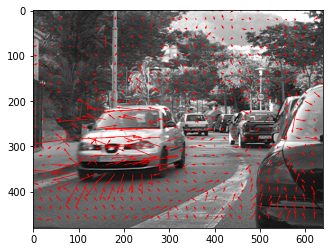

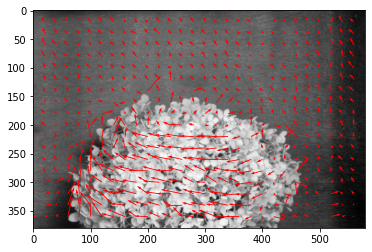

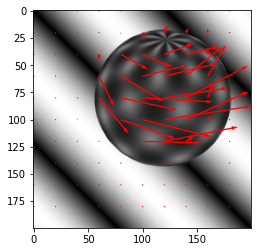

In [9]:
def load_images(name_image_t0, name_image_t1, image_dir="./data/"):
    # Load the two images
    I_t0 = cv2.imread(image_dir + name_image_t0, 0)
    I_t1 = cv2.imread(image_dir + name_image_t1, 0)

    # Convert the to np.float32
    I_t0 = I_t0.astype(np.float32)
    I_t1 = I_t1.astype(np.float32)

    return I_t0, I_t1

def calculate_derivatives(I_t0, I_t1):
    """
    Obtain x, y and time derivatives of an image.
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    derivative_kernel = np.array([[-1, 1, 0]])
    # y_derivative_kernel = np.array([[1], [-1], [0]])
                                #  [2, 0, -2],
                                #  [1, 0, -1]])
    
    I_x = scipy.signal.convolve2d(I_t0, derivative_kernel, mode='same', boundary='symm')
    I_y = scipy.signal.convolve2d(I_t0, derivative_kernel.T, mode='same', boundary='symm')
    I_t = I_t0 - I_t1
    return I_x, I_y, I_t

# Function that separates the image into subregions
def calculate_subregions(I_t0, I_x, I_y, I_t, region_size):
    """
    input: I_t0, I_x, I_y, I_t, region_size
    I_t0: image at time t0
    I_x: image x-derivative
    I_y: image y-derivative
    I_t: image time derivative
    region_size: size of the subregions

    output: sub_I_x, sub_I_y, sub_I_t
    sub_I_x: subregions of the image x-derivative
    sub_I_y: subregions of the image y-derivative
    sub_I_t: subregions of the image time derivative
    """

    # --------------
    # YOUR CODE HERE
    # --------------
    
    h, w = I_t0.shape
    sub_I_x = []
    sub_I_y = []
    sub_I_t = []
    x_coordinates = np.arange(0, w, region_size)
    y_coordinates = np.flip(np.arange(0, h, region_size))
    for in_array, out_array in zip([I_x, I_y, I_t], [sub_I_x, sub_I_y, sub_I_t]):
        rows = np.vsplit(in_array, h/region_size)
        for row in rows:
            blocks = np.hsplit(row, w/region_size)
            out_array.append(blocks)

    sub_I_x = np.vstack(np.array(sub_I_x))
    sub_I_y = np.vstack(np.array(sub_I_y))
    sub_I_t = np.vstack(np.array(sub_I_t))
    return sub_I_x, sub_I_y, sub_I_t


# Function that calulates subregions given corners
def calculate_subregions_for_corners(I_x, I_y, I_t, r, c, region_size):
    """
    Input: I_x, I_y, I_t, r, c, region_size
    I_x, I_y, I_t: image derivatives
    r, c: corners of the subregions
    region_size: size of the subregions

    Output: sub_I_x, sub_I_y, sub_I_t
    sub_I_x, sub_I_y, sub_I_t: subregions of the image derivatives
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    sub_I_x = []
    sub_I_y = []
    sub_I_t = []
    for r_index, c_index in zip(r, c):
        sub_I_x.append(I_x[r_index-(region_size//2):r_index + (region_size//2), c_index-(region_size//2):c_index + (region_size//2)])
        sub_I_y.append(I_y[r_index-(region_size//2):r_index + (region_size//2), c_index-(region_size//2):c_index + (region_size//2)])
        sub_I_t.append(I_t[r_index-(region_size//2):r_index + (region_size//2), c_index-(region_size//2):c_index + (region_size//2)])
    sub_I_x = np.array(sub_I_x)
    sub_I_y = np.array(sub_I_y)
    sub_I_t = np.array(sub_I_t)
    return sub_I_x, sub_I_y, sub_I_t


# Function that computes A, A.T and b for each subregion. Then, estimate
# optical flow (Vx, Vt) as given in Equation 22.
def calculate_flow_vectors(I_x, I_y, I_t):
    """
    Calculate the local image flow vector (Vx, Vy) for each subregion by
    solving the linear system defined above.

    Input: I_x, I_y, I_t
    I_x, I_y, I_t: image derivatives

    Output: Vx, Vy
    Vx, Vy: Two lists containing, respectively, Vx, Vy of each subregion
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    
    A = np.array([I_x.flatten(), I_y.flatten()]).T
    # if np.linalg.det(A.T @ A) == 0:
    #     return 0, 0
    b = -I_t.flatten()
    # Vx, Vy = np.linalg.inv(A.T @ A) @ A.T @ b
    Vx, Vy = np.linalg.lstsq(A, b)[0]
    return Vx, Vy


# Function that plots the optical flow vectors
def plot_optical_flow(image, subregion_indices, V_x, V_y, show=True):
    """
    Input: subregion_indices, V_x, V_y
    subregion_indices: indices of the subregions
    V_x, V_y: optical flow vectors
    """
    # --------------
    # YOUR CODE HERE
    # --------------

    # V_x = [elem * -1 for elem in V_x]
    # V_y = [elem * -1 for elem in V_y]
    plt.imshow(image, cmap="gray")
    h = image.shape[0]
    # np.abs(h - subregion_indices[1])
    # np.flip(subregion_indices[1])
    plt.quiver(subregion_indices[0], subregion_indices[1], V_x, V_y, angles='xy', scale_units="xy", color="red")

    if show:
        plt.show()


# --------------
# YOUR CODE HERE
# --------------
# Add the remainder of your code here. If needed, feel free to define more functions.

def compute_optical_flow(name_image_t0, name_image_t1, region_size, r=[], c=[], plot=True, image_dir="./data/", show=True):
    # load images
    I_t0, I_t1 = load_images(name_image_t0, name_image_t1, image_dir=image_dir)
    h, w = I_t0.shape
    # compute derivatives
    I_x, I_y, I_t = calculate_derivatives(I_t0, I_t1)

    if r == [] and c == []:
        new_h = h
        new_w = w
        if h % region_size != 0:
            new_h = h - (h % region_size)
        if w % region_size != 0:
            new_w = w - (w % region_size)
        I_t0 = I_t0[:new_h, :new_w]
        I_t1 = I_t1[:new_h, :new_w]
        I_x = I_x[:new_h, :new_w]
        I_y = I_y[:new_h, :new_w]
        I_t = I_t[:new_h, :new_w]

        # compute subregions
        sub_I_x, sub_I_y, sub_I_t = calculate_subregions(I_t0, I_x, I_y, I_t, region_size)
        
        x_coordinates = np.arange(0, new_w, region_size)
        y_coordinates = np.arange(0, new_h, region_size)
        x = np.tile(x_coordinates, y_coordinates.shape[0])
        y = np.repeat(y_coordinates, x_coordinates.shape[0])
        subregion_indices = [x, y]    
    else:
        sub_I_x, sub_I_y, sub_I_t = calculate_subregions_for_corners(I_x, I_y, I_t, r, c, region_size)
        subregion_indices = [c, r]
        
    V_x = []
    V_y = []
    for x_region, y_region, t_region in zip(sub_I_x, sub_I_y, sub_I_t):    
        # compute flow vectors
        Vx_region, Vy_region = calculate_flow_vectors(x_region, y_region, t_region)
        V_x.append(Vx_region)
        V_y.append(Vy_region)
        
    if plot:
        # show results
        plot_optical_flow(I_t0, subregion_indices, V_x, V_y, show=show)
    return subregion_indices, V_x, V_y
    
# im1 = cv2.imread("./data/car1.jpg", 0)
# im2 = cv2.imread("./data/car1.jpg", 0)
# fig, axs = plt.subplots(1, 2)
# axs[0] = plt.imshow(im1, cmap="gray")
# axs[1].imshow(im2, cmap="gray")
# fig.show()

subregion_indices, V_x, V_y = compute_optical_flow("car1.jpg", "car2.jpg", 20)
subregion_indices, V_x, V_y = compute_optical_flow("plant1.png", "plant2.png", 20)
subregion_indices, V_x, V_y = compute_optical_flow("sphere1.ppm", "sphere2.ppm", 20)


In the plots above, the optical flow for every image pair is shown. The optical flow is computed quite accurate in all three images. The arrows in the background are very small, which means almost no optical flow, which is accurate compared to what one would expect. For the car image, the results are a bit messier, which is probably due to the fact that the whole scene is moving, instead of just one object. However, for example in the arrows under the car, one can see that the results are still correct, because the car is moving forwards, and this is visible in the arrows pointing downwards.

## Question 2.2 (5-*pts*)

Now you have seen one of the optical flow estimation methods developed by Lucas and Kanade. There are several more methods in the literature. The *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* is one of them. Check their method, compare it to Lucas-Kanade and answer the following questions:

**2.2.1** At what scale do the algorithms operate; i.e local or global? Explain your answer.


**2.2.2** How do the algorithms behave at flat regions? Explain differences/similarities.

Both algorithms operate at local scale. They both compute the optical flow at a specific point from the surrounding pixels and don't use the entire image as input for the estimation. In the Horn-Schunck method the optical flow at one point is computed by using the neighbour pixels, in the Lucas and Kanade method the amount of pixels used might be larger.

At a flat region, the Lucas-Kanade method won't be able to produce accurate optical flow estimations. This is the case because this method relies on the image gradients to determine optical flow. However, in a flat region, the image gradient will be very low. Because of this, no optical flow might be detected while there actually is optical flow.
Instead of the image gradient, the Horn-Schunck method uses the image brightness gradient. It uses the change in brightness over time to determine optical flow. Since there still is change of brightness at a flat region, the Horn-Schunck method will be able to determine the optical flow at that region, unlike the Lucas-Kanade method.

# 3. Feature Tracking (20-pts)

In this part of the assignment, you will implement a simple feature-tracking algorithm. The aim is to extract visual features, like corners, and track them over multiple frames.

## Question 3.1 (18-*pts*)

**3.1.1** Implement a simple feature-tracking algorithm by following below steps **[12pts]**:
    
1. Locate feature points on the first frame by using the Harris Corner Detector, that you implemented in Section 1.

2. Track these points using the Lucas-Kanade algorithm for optical flow estimation, that you implemented in the Section 2.
    
    
**3.1.2** Prepare a video for each sample image sequences. These videos should visualize the initial feature points and the optical flow. Test your implementation and prepare visualization videos for **basketball** and **toy** samples. **[6pts]**

Include a demo function to run your code.

In [10]:
# --------------
# YOUR CODE HERE
# --------------
def feature_tracking(image_folder, sigma, threshold):
    video_name = image_folder.split("/")[-2]
    if not os.path.exists(f"./frames/{video_name}"):
        os.makedirs(f"./frames/{video_name}")
    files = os.listdir(image_folder)
    sorted_files = sorted(files)
    H, r, c = haris_corner_detector(os.path.join(image_folder, sorted_files[0]), sigma, threshold)
    h, w = cv2.imread(os.path.join(image_folder, sorted_files[0]), 0).shape
    plt.scatter(c, r, color='red', s=7)
    for i in range(len(sorted_files) - 1):
        subregion_indices, V_x, V_y = compute_optical_flow(sorted_files[i], sorted_files[i+1], 15, r, c, image_dir=image_folder, plot=False)
        image = cv2.imread(os.path.join(image_folder, sorted_files[i]), 0)
        plt.imshow(image, cmap="gray")
        plot_optical_flow(image, [c, r], V_x, V_y, show=False)
        plt.savefig(f"./frames/{video_name}/{sorted_files[i]}")
        plt.clf()
        r = r + V_y
        r = r.astype(int)
        for i, elem in enumerate(r):
            if elem < 0:
                r[i] = 0
        c = c + V_x
        c = c.astype(int)
        for i, elem in enumerate(c):
            if elem < 0:
                c[i] = 0

if not os.path.exists("./frames"):
    os.makedirs("./frames")
    
image_folder = "./data/basketball/"
feature_tracking(image_folder, 3, 5000)
image_folder = "./data/toy/"
feature_tracking(image_folder, 3, 900)

/Users/machameijer/anaconda3/envs/cv1/lib/python3.6/site-packages/ipykernel_launcher.py:155: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/machameijer/anaconda3/envs/cv1/lib/python3.6/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/machameijer/anaconda3/envs/cv1/lib/python3.6/site-packages/ipykernel_launcher.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/machameijer/anaconda3/envs/cv1/lib/python3.6/site-packages/ipykernel_launcher.py:90: VisibleDep

<Figure size 432x288 with 0 Axes>

In [11]:
def create_video(frames_folder, video_name):
    images = [img for img in os.listdir(frames_folder)]
    images.sort()
    frame = cv2.imread(os.path.join(frames_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, -1, 15, (width,height))
    for image in images:
        video.write(cv2.imread(os.path.join(frames_folder, image)))
    video.release()

frames_folder = './frames/toy/'
video_name = 'toy.mp4'
create_video(frames_folder, video_name)
frames_folder = './frames/basketball/'
video_name = 'basketball.mp4'
create_video(frames_folder, video_name)

In [12]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open("./basketball.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

In [13]:

mp4 = open("./toy.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

In the videos above, the results of combining the corner detection algorithm with the optical flow algorithm are shown as a video. The results for the toy video are very good. Corners are mostly detected around the toy, which is as expected, and these corners have an optical flow to the left for almost the entire time, which is also as one would expect. The only error is that the arrows are pointing upwards a bit, which causes the predicted corners to shift upwards too, so at the end of the video, the new corner position is not correct anymore.

For the basketball video, the results are less good. The corner prediction is mostly accurate, but there are a few false corners predicted on the boundary between the ground and the trees. The optical flow prediction is okay at the start, until the basketball starts occluding the original keypoints. This causes the keypoints to shift from their original point onto the basketball since the colors are quite similar. 

## Question  3.2 (2-*pts*)

Why do we need feature tracking even though we can detect features for each and every frame?

We need feature tracking because the detection of features in separate frames does not tell us anything about which feature is which. For example, if you want to track two objects with similar features over time, only feature detection does not give you enough information, because you want to be able to distinguish between objects.

# X Individual Contribution Report *(Mandatory)*

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.


Name: Macha Meijer

Contribution on research: 50 \
Contribution on programming: 50 \
Contribution on writing: 50 

Name: Karim Abdel Sadek

Contribution on research: 50 \
Contribution on programming: 50 \
Contribution on writing: 50

Name:

Contribution on research: \
Contribution on programming: \
Contribution on writing:

Name:

Contribution on research: \
Contribution on programming: \
Contribution on writing:

# - End of notebook -